In [13]:
import os
import string
import re

import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Generate graphs in SVG format
%config InlineBackend.figure_format = 'svg'

# get reproducible results
np.random.seed(1997)
tf.random.set_seed(1997)

In [14]:
df = pd.read_csv('data/presidential_speeches_cleaned.csv', encoding='utf-8', usecols=['Party', 'Transcript'])
df.sample(5)

,Party,Transcript
421,Democratic,My fellow Americans: Washington's Birthday is ...
373,Republican,Members of the American Bankers Association an...
648,Republican,"Officers, ladies and gentlemen of the National..."
256,Republican,To the Senate and House of Representatives: No...
615,Republican,"Mr. Chairman, delegates and alternates to this..."


In [15]:
df['Party'].value_counts()

Democratic    489
Republican    389
Name: Party, dtype: int64

In [16]:
X = df.drop('Party', axis=1)
y = df['Party']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=97, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((702, 1), (176, 1), (702,), (176,))

In [17]:
OUTPUT_PATH = os.path.join(os.getcwd(), 'data/speeches_split')

for directory in (
        '', 
        'train', 
        'test', 
        'train/Republican', 
        'train/Democratic', 
        'test/Republican', 
        'test/Democratic'
    ):
    if not os.path.exists(os.path.join(OUTPUT_PATH, directory)):
        os.mkdir(os.path.join(OUTPUT_PATH, directory))

for i in range(len(X_train)):

    file_num = f'{i+1}'.zfill(4)
    label = y_train.iloc[i]

    with open(
        f'{OUTPUT_PATH}/train/{label}/{file_num}.txt',
        'w', encoding='utf-8'
    ) as f:
        f.write(X_train.iloc[i]['Transcript'])

In [18]:
for i in range(len(X_test)):

    file_num = f'{i+1}'.zfill(4)
    label = y_test.iloc[i]

    with open(
        f'{OUTPUT_PATH}/test/{label}/{file_num}.txt',
        'w', encoding='utf-8'
    ) as f:
        f.write(X_test.iloc[i]['Transcript'])

In [19]:
batch_size = 100

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    f'{OUTPUT_PATH}/train',
    batch_size=batch_size,
    validation_split=0.1,
    labels='inferred',
    label_mode='binary',
    subset='training',
    seed=1997,
)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    f'{OUTPUT_PATH}/train',
    batch_size=batch_size,
    validation_split=0.1,
    labels='inferred',
    label_mode='binary',
    subset='validation',
    seed=1997,
)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    f'{OUTPUT_PATH}/test', batch_size=batch_size
)

print("\n")
print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 702 files belonging to 2 classes.
Using 632 files for training.
Found 702 files belonging to 2 classes.
Using 70 files for validation.
Found 176 files belonging to 2 classes.


Number of batches in raw_train_ds: 7
Number of batches in raw_val_ds: 1
Number of batches in raw_test_ds: 2


In [20]:
from IPython.display import Markdown, display

# Examples
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(f"Example {i+1}:")
        print(text_batch.numpy()[i][:250])
        print('Republican' if label_batch.numpy()[i] == 1. else 'Democratic')
        display(Markdown('---'))

Example 1:
b"Good evening. I want to have a frank talk with you tonight about our most serious domestic problem. That problem is inflation. Inflation can threaten all the economic gains we've made, and it can stand in the way of what we want to achieve in the fut"
Democratic


---

Example 2:
b'IN APRIL 1928, as a result of discussions between our Secretary of State of the United States and the Minister of Foreign Affairs of France, the President directed Secretary Kellogg to propose to the nations of the world that they should enter into a'
Republican


---

Example 3:
b'I have just concluded a meeting with the leaders of the Congress. I reported to them on the serious situation in the Dominican Republic. I reported the decisions that this Government considers necessary in this situation in order to protect American '
Democratic


---

Example 4:
b'To the Senate and House of Representatives: The Constitution requires that the President \xe2\x80\x9cshall, from time to time, give to the Congress information of the state of the Union, and recommend to their consideration such measures as he shall judge nec'
Republican


---

Example 5:
b"Mr. Speaker, Mr. President, Members of the Congress, distinguished guests, and my fellow Americans: It's great to be home, and Nancy and I thank you for this wonderful homecoming. And before I go on, I want to say a personal thank you to Nancy. She w"
Republican


---

In [21]:
def clean(input_data):
    text = tf.strings.lower(input_data)
    return tf.strings.regex_replace(
        text, f'[{re.escape(string.punctuation)}]', ''
    )

# Constants for the model
max_features = 5000
embedding_dim = 128
sequence_length = 128

vect = keras.layers.TextVectorization(
    standardize=clean,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)

text_ds = raw_train_ds.map(lambda x, y: x)
vect.adapt(text_ds)

In [22]:
# Vectorize the texts
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vect(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds   = raw_val_ds.map(vectorize_text)
test_ds  = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds   = val_ds.cache().prefetch(buffer_size=10)
test_ds  = test_ds.cache().prefetch(buffer_size=10)

In [23]:
# An integer input for vocab indices
inputs = keras.Input(shape=(None,), dtype='int64')

# A layer to map those vocab indices into a space of dimensionality
x = keras.layers.Embedding(max_features, embedding_dim)(inputs)
x = keras.layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = keras.layers.Conv1D(256, 1, padding='same', activation='relu')(x)
x = keras.layers.Conv1D(256, 1, padding='same', activation='relu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)

x = keras.layers.Dense(128, activation='relu', name='relu1')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu', name='relu2')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='softmax', name='softmax')(x)
x = keras.layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = keras.layers.Dense(1, activation='sigmoid', name='output')(x)

# Add early stopping to prevent overfitting, and the optimizer
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model = keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         640000    
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 256)         33024     
                                                                 
 conv1d_3 (Conv1D)           (None, None, 256)         65792     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                           

In [24]:
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 6s 684ms/step - loss: 0.6934 - accuracy: 0.4889 - val_loss: 0.6932 - val_accuracy: 0.4571
Epoch 2/100
7/7 [==============================] - 1s 207ms/step - loss: 0.6935 - accuracy: 0.4731 - val_loss: 0.6932 - val_accuracy: 0.4571
Epoch 3/100
7/7 [==============================] - 1s 200ms/step - loss: 0.6937 - accuracy: 0.4620 - val_loss: 0.6931 - val_accuracy: 0.5286
Epoch 4/100
7/7 [==============================] - 1s 206ms/step - loss: 0.6934 - accuracy: 0.4810 - val_loss: 0.6931 - val_accuracy: 0.5429
Epoch 5/100
7/7 [==============================] - 2s 221ms/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6931 - val_accuracy: 0.5429
Epoch 6/100
7/7 [==============================] - 1s 191ms/step - loss: 0.6933 - accuracy: 0.4873 - val_loss: 0.6930 - val_accuracy: 0.5429
Epoch 7/100
7/7 [==============================] - 2s 254ms/step - loss: 0.6930 - accuracy: 0.5174 - val_loss: 0.6930 - val_accuracy: 0.5429
Epoch 8/100
7

In [25]:
model.evaluate(test_ds)

2/2 [==============================] - 1s 181ms/step - loss: 0.6773 - accuracy: 0.5568


[0.6773464679718018, 0.5568181872367859]

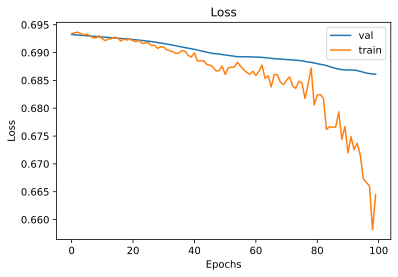

In [26]:
plt.plot(history.history['val_loss'], label='val')
plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

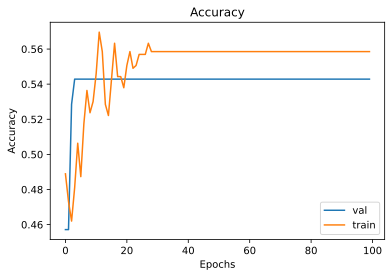

In [27]:
plt.plot(history.history['val_accuracy'], label='val')
plt.plot(history.history['accuracy'], label='train')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()